# Model Launch
### Installing the Dependincies

In [1]:
# requirements 
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [13]:
# Let's analyze our dataset

In [2]:
path = 'S038_whole_df.csv'
path_df = pd.read_csv(path)
print("Sleep stages in dataset dist:")
print(path_df['Sleep_Stage'].value_counts())

Sleep stages in dataset dist:
Sleep_Stage
N2    768000
P     483328
N1    318720
R     232320
W     192001
Name: count, dtype: int64


In total, we have 1,994,369 epochs distributed as follows: N2 is by far the most common stage with 768,000 epochs (≈38.5 %), followed by P with 483,328 epochs (≈24.2 %), N1 with 318,720 epochs (≈16.0 %), R with 232,320 epochs (≈11.6 %), and W with just 192,001 epochs (≈9.6 %)

# Model Selection

### 2.1 RandomForestClassifier

In [16]:
# First we define our label map 
# Each sleep stage code (e.g. 'W' for wake, 'N2' for NREM stage 2) to a numeric label 0–4, and then giving each numeric index
# In our original dataset CSV had rows marked for “prep” or setup that you don’t want to include, this keeps only the actual sleep‐stage epochs (W, N1, N2, N3, R) and re-indexes the DataFrame
# Since our acceloramaeter data is at 32 Hz we want to chunk it into 30 seconds windows, so each window contains 32×30 = 960 samples

# Source : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### For this implementation we will follow this structure: 

We first load it into a pandas DataFrame and immediately drop any "prep" rows to leave us with pure sleep‐stage epochs (Wake, N1, N2, N3, REM). We next assign a number to each stage label (0–4) and pull out the accelerometer axes (ACC_X, ACC_Y, ACC_Z) and heart‐rate (HR) as NumPy arrays. Having discovered that our accelerometer is sampled at 32 Hz and we want 30 s epochs, we compute each epoch to be 960 samples long and loop over those windows. For each epoch, we slice the three axes of accelerometer data and the 30 HR samples, compute the movement intensity (acceleration magnitude) and standard deviation as a proxy of movement intensity, and then create a nine‐dimensional feature vector (mean ± SD of each axis, mean ± SD of HR, movement intensity). We label each feature vector with the sleep stage at the end of its window. After we transformed our list of feature vectors and labels into NumPy arrays, we split them 70/30 into test and training sets and trained a 100‐tree Random Forest on the nine features. Finally, we predict on the held‐out test set and simply report precision, recall, and F1 for the actual stages occurring—using scikit-learn's unique_labels to avoid matches—so we have a sharp, objective measure of the extent to which our simple feature‐based classifier is able to distinguish between the different sleep stages

In [35]:
label_map = {'W': 0, 
             'N1': 1, 
             'N2': 2, 
             'N3': 3, 
             'R': 4} 
label_names = ['Wake', 
               'NREM Stage 1', 
               'NREM Stage 2', 
               'NREM Stage 3', 
               'REM']

no_preparation = ['W', 'N1', 'N2', 'N3', 'R']
path_df = path_df[path_df['Sleep_Stage'].isin(no_preparation)].reset_index(drop=True) 
sampling_freq = 32
epoch_len = 30  
samples_per_epoch = sampling_freq*epoch_len

#rows_per_hour = sampling_freq*60*60*3 #1 hr of data
#path_df = path_df.iloc[:hr]
#max_rows = min(len(path_df), rows_per_hour)
#path_df = path_df.iloc[:max_rows]

path_df['Label'] = path_df['Sleep_Stage'].map(label_map)

acc_x = path_df['ACC_X'].to_numpy() 
acc_y = path_df['ACC_Y'].to_numpy()
acc_z = path_df['ACC_Z'].to_numpy()

#heart rate
heart_rate = path_df['HR'].to_numpy() 
labels = path_df['Label'].to_numpy()
samples_per_epoch = sampling_freq*epoch_len
num_epochs = len(acc_x)//samples_per_epoch
features = []
epoch_labels = []

for epoch in range(num_epochs):
    start = epoch*samples_per_epoch
    end = (epoch+1)*samples_per_epoch 
    
    #getting relevant sections for each epoch
    #x axis section,y axis section, z axis section
    x = acc_x[start:end] 
    y = acc_y[start:end] 
    z = acc_z[start:end] 
    #since its 1 hz
    hr_start = epoch*30  
    hr_end = (epoch+1)*30
    hr = heart_rate[hr_start:hr_end] #heart rate section
    acc_magnitude = np.sqrt(x**2+y**2+z**2)
    movement_intensity = np.std(acc_magnitude)

    #for feature extraction
    #using simple mean and std 
    feats = [
        np.mean(x), np.std(x),
        np.mean(y), np.std(y),
        np.mean(z), np.std(z),
        np.mean(hr), np.std(hr),
        movement_intensity
        
    ] #extracted feature vector
    features.append(feats)
    epoch_labels.append(labels[end-1]) 
    #append sleep stage label

features = np.array(features)
epoch_labels = np.array(epoch_labels)
move = features[:, 8]
for stage in np.unique(epoch_labels):
    stage_name = label_names[stage]
    movement_std = np.mean(move[epoch_labels == stage])
    print(f"{stage_name}: {movement_std}")

#split into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(features, epoch_labels, test_size=0.3, random_state=1)
clf = RandomForestClassifier(n_estimators=100, random_state=1) 
#random forest good for high dim data and super fast
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

from sklearn.utils.multiclass import unique_labels
used_labels = unique_labels(y_test, y_pred)
used_names = [label_names[i] for i in used_labels]

print(classification_report(y_test, y_pred, target_names=used_names))
#print(classification_report(y_test, y_pred, target_names=label_names))

Wake: 1.3718981293942167
NREM Stage 1: 0.27213130647577305
NREM Stage 2: 0.35568989681819196
REM: 0.4507631393965211
              precision    recall  f1-score   support

        Wake       0.88      0.78      0.83        59
NREM Stage 1       0.69      0.66      0.68        89
NREM Stage 2       0.87      0.93      0.90       255
         REM       0.95      0.90      0.93        70

    accuracy                           0.85       473
   macro avg       0.85      0.82      0.83       473
weighted avg       0.85      0.85      0.85       473



### Confussion Matrix and Visualizaiton

This code tracks and plots our training loss over epochs

- It initializes an empty list loss_history.

- In each epoch , it sums up the batch losses, divides by the total number of samples to get the average training loss for that epoch, appends it to loss_history, and prints it.

- After training, it calls Matplotlib to draw a line plot of loss_history vs. epoch number, labels the axes “Epoch” and “Training Loss,” adds a grid, and pops up the figure.


Then , it computes and visualizes a confusion matrix

 - It uses confusion_matrix(y_true, y_pred, labels=unique_labels) from scikit-learn to build a matrix cm where row i, column j is the count of true-label=i predicted as=

 - It then creates a new Matplotlib figure, displays cm as a heatmap (plt.imshow), and adds a colorbar

 - The x- and y-axis ticks are set to our target_names (rotated on the x-axis for readability)

 - Finally, it loops over every cell in the matrix and writes the integer count in the middle, switching text color to white or black depending on whether the cell is darker or lighter than half the max value, then tightens up the layout and shows the plot





Epoch 1/50 — train_loss: 0.4592
Epoch 2/50 — train_loss: 0.4610
Epoch 3/50 — train_loss: 0.4770
Epoch 4/50 — train_loss: 0.4483
Epoch 5/50 — train_loss: 0.4584
Epoch 6/50 — train_loss: 0.4574
Epoch 7/50 — train_loss: 0.4672
Epoch 8/50 — train_loss: 0.4755
Epoch 9/50 — train_loss: 0.4432
Epoch 10/50 — train_loss: 0.4651
Epoch 11/50 — train_loss: 0.4438
Epoch 12/50 — train_loss: 0.4479
Epoch 13/50 — train_loss: 0.4930
Epoch 14/50 — train_loss: 0.4743
Epoch 15/50 — train_loss: 0.4684
Epoch 16/50 — train_loss: 0.4681
Epoch 17/50 — train_loss: 0.4589
Epoch 18/50 — train_loss: 0.4744
Epoch 19/50 — train_loss: 0.4582
Epoch 20/50 — train_loss: 0.4792
Epoch 21/50 — train_loss: 0.4642
Epoch 22/50 — train_loss: 0.4655
Epoch 23/50 — train_loss: 0.4669
Epoch 24/50 — train_loss: 0.4770
Epoch 25/50 — train_loss: 0.4553
Epoch 26/50 — train_loss: 0.4808
Epoch 27/50 — train_loss: 0.4581
Epoch 28/50 — train_loss: 0.4400
Epoch 29/50 — train_loss: 0.4697
Epoch 30/50 — train_loss: 0.4426
Epoch 31/50 — train

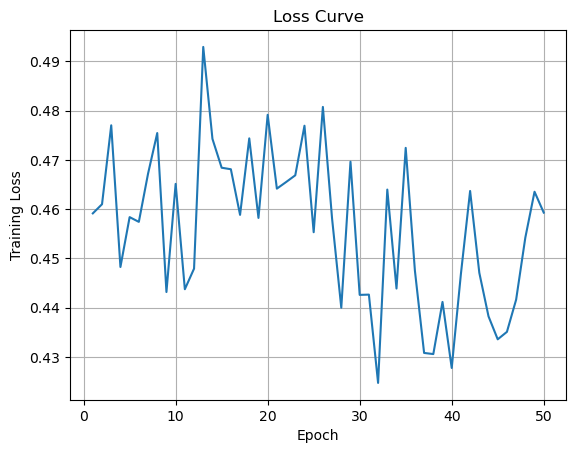

InvalidParameterError: The 'labels' parameter of confusion_matrix must be an array-like or None. Got <function unique_labels at 0x31b074f40> instead.

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# During training, record our loss each epoch 
loss_history = []

for ep in range(1, epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss   = loss_fn(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_dl.dataset)
    loss_history.append(avg_loss)
    print(f"Epoch {ep}/{epochs} — train_loss: {avg_loss:.4f}")

# After evaluation, plot our loss curve 
plt.figure()
plt.plot(range(1, epochs+1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve")
plt.grid(True)
plt.show()

# Compute a confusion matrix 
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
# tick positions
ticks = range(len(unique_labels))
plt.xticks(ticks, [target_names[i] for i in range(len(ticks))], rotation=45, ha="right")
plt.yticks(ticks, [target_names[i] for i in range(len(ticks))])
# annotate each cell
thresh = cm.max() / 2
for i in ticks:
    for j in ticks:
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


### MLP Design and LSTM

This script imitation a simple feed-forward neural network, wraps it in a reusable train-and-evaluate function, and then uses those tools to train and compare both an LSTM (defined elsewhere) and this new MLP on our sleep-stage data. The SleepMLP class first flattens each 30×4 epoch into a 120-dim vector, then applies a single hidden layer with ReLU and dropout, and finally outputs five class scores. The train_and_evaluate helper function places any model on GPU if available, trains the standard PyTorch training loop for some number of epochs—tracking and printing average training loss per epoch—then places the model in evaluation mode to make predictions on the held-out test set and returns per-epoch loss history, test accuracy, and confusion matrix. After constructing your train_dl and test_dl DataLoaders from the same SleepDataset and data splits we established above, the script instantiates both your LSTM and new MLP, trains each in sequence with live loss feedback, then prints a side-by-side table of LSTM vs. MLP train losses by epoch and each model's final test accuracy, so we immediately know which design learns faster and generalizes better before proceeding to plotting or further analysis

In [37]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Define our MLP 
class SleepMLP(nn.Module):
    def __init__(self, input_dim=30*4, hidden_dim=128, num_classes=5, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        
        # x: (B, 30, 4) → flatten to (B, 120)
        
        x = x.view(x.size(0), -1)
        return self.net(x)

# Helper to train & eval one model
def train_and_evaluate(model, train_dl, test_dl, epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    loss_hist = []
    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item() * xb.size(0)
        avg = total_loss / len(train_dl.dataset)

        loss_hist.append(avg)
        #live feedback 
        print(f"[Epoch {ep:>2}] train_loss = {avg:.4f}")   

    # evaluation
    
    model.eval()
    all_pred, all_true = [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            preds = model(xb).argmax(dim=1).cpu().numpy()
            all_pred.append(preds)
            all_true.append(yb.numpy())
    y_pred = np.concatenate(all_pred)
    y_true = np.concatenate(all_true)

    acc = accuracy_score(y_true, y_pred)
    cm  = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    return loss_hist, acc, cm, np.unique(y_true)

# Build our DataLoaders 
# Reusing the SleepDataset,

train_dl = DataLoader(SleepDataset(X_tr,y_tr), batch_size=32, shuffle=True)
test_dl  = DataLoader(SleepDataset(X_te,y_te), batch_size=32)

# Instantiate & run 
lstm_model = SleepLSTM()    
mlp_model  = SleepMLP()

print("=== Training LSTM ===")
lstm_loss, lstm_acc, lstm_cm, labels_l = train_and_evaluate(lstm_model, train_dl, test_dl)

print("\n=== Training MLP ===")
mlp_loss,  mlp_acc,  mlp_cm,  labels_m = train_and_evaluate(mlp_model,  train_dl, test_dl)

# FINAL SUMMARY 
print("\nEpoch |   LSTM Loss   |   MLP Loss")
for i, (l_lstm, l_mlp) in enumerate(zip(lstm_loss, mlp_loss), start=1):
    print(f"{i:>2}    |    {l_lstm:.4f}    |    {l_mlp:.4f}")

print(f"\nLSTM Test Accuracy: {lstm_acc:.4f}")
print(f"MLP  Test Accuracy: {mlp_acc:.4f}")


=== Training LSTM ===
[Epoch  1] train_loss = 1.1779
[Epoch  2] train_loss = 0.8102
[Epoch  3] train_loss = 0.7417
[Epoch  4] train_loss = 0.7025
[Epoch  5] train_loss = 0.7469
[Epoch  6] train_loss = 0.7051
[Epoch  7] train_loss = 0.6636
[Epoch  8] train_loss = 0.6553
[Epoch  9] train_loss = 0.6580
[Epoch 10] train_loss = 0.6338
[Epoch 11] train_loss = 0.6190
[Epoch 12] train_loss = 0.5987
[Epoch 13] train_loss = 0.5993
[Epoch 14] train_loss = 0.5948
[Epoch 15] train_loss = 0.6248
[Epoch 16] train_loss = 0.6264
[Epoch 17] train_loss = 0.5923
[Epoch 18] train_loss = 0.5947
[Epoch 19] train_loss = 0.5811
[Epoch 20] train_loss = 0.5981

=== Training MLP ===
[Epoch  1] train_loss = 5.5679
[Epoch  2] train_loss = 1.9439
[Epoch  3] train_loss = 1.1362
[Epoch  4] train_loss = 0.9584
[Epoch  5] train_loss = 0.8918
[Epoch  6] train_loss = 0.8435
[Epoch  7] train_loss = 0.8355
[Epoch  8] train_loss = 0.8312
[Epoch  9] train_loss = 0.8053
[Epoch 10] train_loss = 0.8402
[Epoch 11] train_loss = 0.

In [11]:
# Visualization and Compare

=== Training LSTM ===
[Epoch  1] train_loss = 1.2501
[Epoch  2] train_loss = 0.8004
[Epoch  3] train_loss = 0.7048
[Epoch  4] train_loss = 0.6932
[Epoch  5] train_loss = 0.6773
[Epoch  6] train_loss = 0.6680
[Epoch  7] train_loss = 0.6185
[Epoch  8] train_loss = 0.6202
[Epoch  9] train_loss = 0.6398
[Epoch 10] train_loss = 0.6368
[Epoch 11] train_loss = 0.6384
[Epoch 12] train_loss = 0.6197
[Epoch 13] train_loss = 0.6014
[Epoch 14] train_loss = 0.6086
[Epoch 15] train_loss = 0.6212
[Epoch 16] train_loss = 0.6602
[Epoch 17] train_loss = 0.6618
[Epoch 18] train_loss = 0.6375
[Epoch 19] train_loss = 0.6132
[Epoch 20] train_loss = 0.6453

=== Training MLP ===
[Epoch  1] train_loss = 4.4275
[Epoch  2] train_loss = 1.8560
[Epoch  3] train_loss = 1.1616
[Epoch  4] train_loss = 0.9707
[Epoch  5] train_loss = 0.8396
[Epoch  6] train_loss = 0.8021
[Epoch  7] train_loss = 0.7802
[Epoch  8] train_loss = 0.7905
[Epoch  9] train_loss = 0.7952
[Epoch 10] train_loss = 0.7767
[Epoch 11] train_loss = 0.

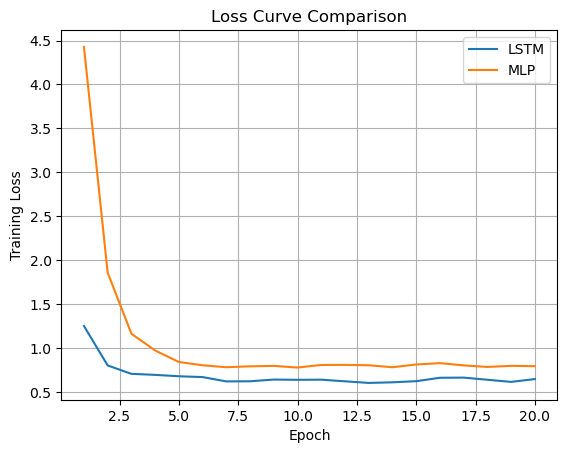

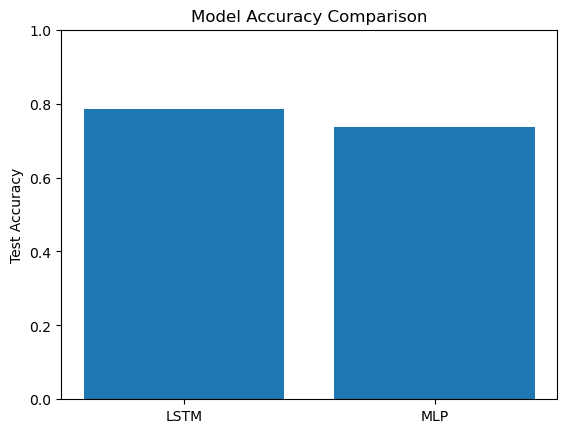

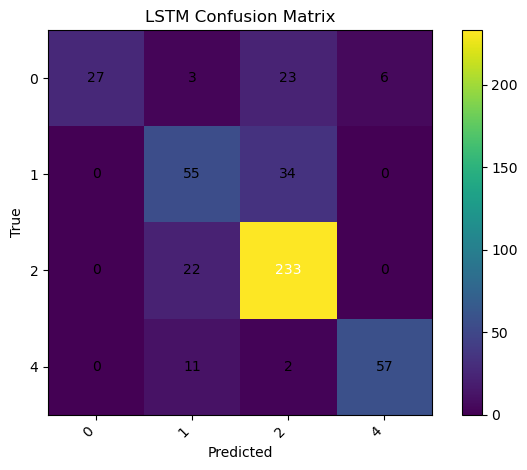

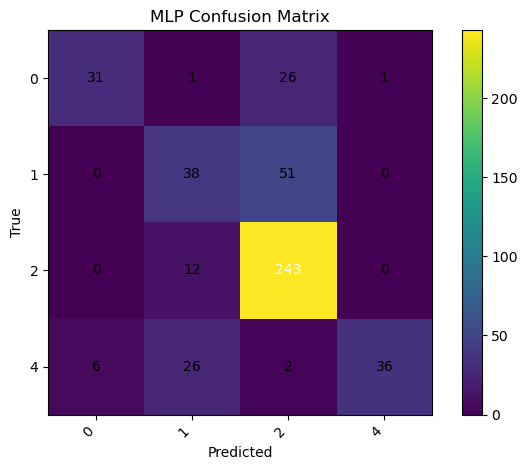

In [12]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Train_and_evaluate helper
def train_and_evaluate(model, train_dl, test_dl, epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    loss_hist = []
    for ep in range(1, epochs+1):
        model.train()
        total = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item() * xb.size(0)
        avg = total / len(train_dl.dataset)
        loss_hist.append(avg)
        print(f"[Epoch {ep:>2}] train_loss = {avg:.4f}")

    model.eval()
    all_p, all_t = [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            preds = model(xb).argmax(dim=1).cpu().numpy()
            all_p.append(preds)
            all_t.append(yb.numpy())
    y_pred = np.concatenate(all_p)
    y_true = np.concatenate(all_t)

    acc = accuracy_score(y_true, y_pred)
    cm  = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    return loss_hist, acc, cm, np.unique(y_true)

# Instantiate & run 
print("=== Training LSTM ===")
lstm_model = SleepLSTM()
lstm_loss, lstm_acc, lstm_cm, labels_l = train_and_evaluate(lstm_model, train_dl, test_dl)

print("\n=== Training MLP ===")
mlp_model  = SleepMLP()
mlp_loss,  mlp_acc,  mlp_cm,  labels_m = train_and_evaluate(mlp_model,  train_dl, test_dl)


# Summary table of losses & accuracies 
print("\nEpoch |   LSTM Loss   |   MLP Loss")
for i, (l_l, l_m) in enumerate(zip(lstm_loss, mlp_loss), start=1):
    print(f"{i:>3}    |   {l_l:.4f}    |   {l_m:.4f}")
print(f"\nLSTM Test Accuracy: {lstm_acc:.4f}")
print(f"MLP  Test Accuracy: {mlp_acc:.4f}")


# Plot loss curves 
plt.figure()
plt.plot(range(1, len(lstm_loss)+1), lstm_loss, label='LSTM')
plt.plot(range(1, len(mlp_loss)+1),  mlp_loss,  label='MLP')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Loss Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


# Bar chart of test accuracies
plt.figure()
plt.bar(['LSTM','MLP'], [lstm_acc, mlp_acc])
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0,1)
plt.show()


# Confusion matrices 
def plot_cm(cm, labels, title):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    ticks = range(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    thresh = cm.max() / 2
    for i in ticks:
        for j in ticks:
            plt.text(j, i, cm[i,j], ha='center', va='center',
                     color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.show()

plot_cm(lstm_cm, labels_l, "LSTM Confusion Matrix")
plot_cm(mlp_cm, labels_m,  "MLP Confusion Matrix")


In [8]:
import joblib

# Save the model
joblib.dump(clf, 'sleep_stage_classifier.joblib')
feature_names = ['acc_x_mean', 'acc_x_std', 'acc_y_mean', 'acc_y_std', 
                'acc_z_mean', 'acc_z_std', 'hr_mean', 'hr_std', 'movement_intensity']
joblib.dump(feature_names, 'feature_names.joblib')

['feature_names.joblib']

In [10]:
import numpy as np
import pandas as pd
import joblib
import os

# Load the test heart rate data
def load_heart_rate_data(file_path):
    """
    Load heart rate data from a file.
    Handles multiple formats (CSV or text).
    """
    try:
        # Try to load as CSV first
        df = pd.read_csv(file_path)
        if 'heart_rate' in df.columns:
            return df['heart_rate'].values
        else:
            column_name = df.columns[1] if len(df.columns) > 1 else df.columns[0]
            return df[column_name].values
    except:
        try:
            lines = []
            with open(file_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 1:
                        try:
                            hr = float(parts[1])
                            lines.append(hr)
                        except:
                            pass
            return np.array(lines)
        except Exception as e:
            print(f"Error loading heart rate data: {e}")
            return None

# Simulate accelerometer data
def simulate_acc_data(heart_rates, num_samples_per_epoch=960):
    """
    Simulate accelerometer data based on heart rates
    Higher heart rate typically means more movement
    
    Parameters:
    - heart_rates: array of heart rate values for each epoch
    - num_samples_per_epoch: number of accelerometer samples per epoch (32Hz * 30s = 960)
    
    Returns:
    - Dictionary containing simulated accelerometer data for each epoch
    """
    acc_data = {
        'acc_x': [],
        'acc_y': [],
        'acc_z': []
    }
    
    for hr in heart_rates:
        
        # Scale movement intensity based on heart rate
        # Lower heart rate (e.g., deep sleep) = less movement
        # Higher heart rate (e.g., wake) = more movement
        
        if hr < 50:  # Deep sleep
            intensity = 0.01
        elif hr < 60:  # Light sleep
            intensity = 0.03
        elif hr < 80:  # REM sleep
            intensity = 0.05
        else:  # Likely awake
            intensity = 0.1
            
        # Generate simulated accelerometer data
        # X and Y axes typically have more variation during movement
        # Z axis often shows gravity (~9.8) with some variation
        
        x = np.random.normal(0, intensity, num_samples_per_epoch)
        y = np.random.normal(0, intensity, num_samples_per_epoch)
        z = np.random.normal(9.8, intensity/2, num_samples_per_epoch)
        
        acc_data['acc_x'].append(x)
        acc_data['acc_y'].append(y)
        acc_data['acc_z'].append(z)
        
    return acc_data

# Extract features from heart rate and accelerometer data
def extract_features(heart_rates, acc_data=None):
    """
    Extract features used by the sleep stage classification model
    
    Parameters:
    - heart_rates: array of heart rate values for each epoch (30s)
    - acc_data: dictionary of accelerometer data (optional, will be simulated if None)
    
    Returns:
    - Features array in the format expected by the model
    """
    num_epochs = len(heart_rates)
    features = []
    
    # If accelerometer data was not provided, simulate it
    if acc_data is None:
        acc_data = simulate_acc_data(heart_rates)
    
    for i in range(num_epochs):
        # Get heart rate for this epoch (assuming 1 value per epoch)
        hr = heart_rates[i]
        
        # Get accelerometer data for this epoch
        x = acc_data['acc_x'][i]
        y = acc_data['acc_y'][i]
        z = acc_data['acc_z'][i]
        
        # Calculate acceleration magnitude
        acc_magnitude = np.sqrt(x**2 + y**2 + z**2)
        movement_intensity = np.std(acc_magnitude)
        
        # Create feature vector matching the training features
        feat = [
            np.mean(x), np.std(x),
            np.mean(y), np.std(y),
            np.mean(z), np.std(z),
            hr, 0,  # HR mean and std (using single value, so std=0)
            movement_intensity
        ]
        
        features.append(feat)
    
    return np.array(features)

# Test the model on the provided data
def test_sleep_model(model_path, heart_rate_data_path):
    """
    Test the sleep stage classification model on heart rate data
    
    Parameters:
    - model_path: path to the saved model file (.joblib)
    - heart_rate_data_path: path to the heart rate data file
    
    Returns:
    - Predicted sleep stages for each epoch
    """
    # Load the model
    try:
        model = joblib.load(model_path)
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None
    
    # Load heart rate data
    heart_rates = load_heart_rate_data(heart_rate_data_path)
    if heart_rates is None:
        return None
    
    print(f"Loaded {len(heart_rates)} heart rate measurements")
    
    # Extract features
    features = extract_features(heart_rates)
    print(f"Extracted features for {len(features)} epochs")
    
    # Make predictions
    predictions = model.predict(features)
    
    # Map numeric predictions to stage names
    label_names = ['Wake', 'NREM Stage 1', 'NREM Stage 2', 'NREM Stage 3', 'REM']
    predicted_stages = [label_names[pred] for pred in predictions]
    
    # Create a results dataframe
    results = pd.DataFrame({
        'Epoch': range(1, len(heart_rates) + 1),
        'Heart_Rate': heart_rates,
        'Predicted_Stage_Num': predictions,
        'Predicted_Stage': predicted_stages
    })
    
    # Save results
    results.to_csv('sleep_stage_predictions.csv', index=False)
    print("Predictions saved to sleep_stage_predictions.csv")
    
    # Print a summary
    stage_counts = results['Predicted_Stage'].value_counts()
    print("\nSleep Stage Prediction Summary:")
    for stage, count in stage_counts.items():
        percentage = (count / len(results)) * 100
        print(f"{stage}: {count} epochs ({percentage:.1f}%)")
    
    return results

# Main execution
if __name__ == "__main__":
    model_path = "sleep_stage_classifier.joblib"
    heart_rate_data_path = "heart_rate_results.csv"
    
    # Check if files exist
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        print("Please make sure to save your trained model first!")
    elif not os.path.exists(heart_rate_data_path):
        print(f"Heart rate data file not found: {heart_rate_data_path}")
        print("Please save your heart rate data to a file first!")
    else:
        # Run the test
        results = test_sleep_model(model_path, heart_rate_data_path)
        if results is not None:
            print("\nPrediction complete!")

Successfully loaded model from sleep_stage_classifier.joblib
Loaded 186 heart rate measurements
Extracted features for 186 epochs
Predictions saved to sleep_stage_predictions.csv

Sleep Stage Prediction Summary:
NREM Stage 2: 167 epochs (89.8%)
Wake: 19 epochs (10.2%)

Prediction complete!
